# Machine Learning 3

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

**Dataset**

The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

**Description of Variables**

The dataset contains 6366 observations of 9 variables:

rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)

age: woman's age

yrs_married: number of years married

children: number of children

religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)

educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)

occupation: woman's occupation (1 = student, 2 = farming/semi- skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)

occupation_husb: husband's occupation (same coding as above)

affairs: time spent in extra-marital affairs

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

df = sm.datasets.fair.load_pandas().data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


### Understanding Data / Data Preprocessing

In [17]:
# Add had_affair column
df["had_affair"] = (df["affairs"] > 0).astype(int)
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,had_affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [21]:
df.groupby("had_affair").mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
had_affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Looks like on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the `rate_marriage` variable.

In [22]:
df.groupby("rate_marriage").mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,had_affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


An increase in `age`, `yrs_married`, and `children` appears to correlate with a declining marriage rating.

### Data Analysis and Visualization

Text(0, 0.5, 'Frequency')

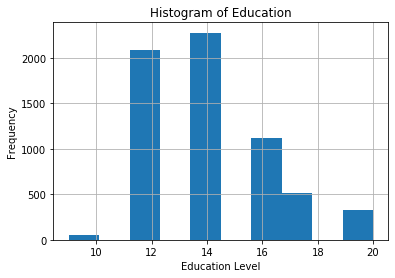

In [25]:
# histogram of education
df["educ"].hist()
plt.title("Histogram of Education")
plt.xlabel("Education Level")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

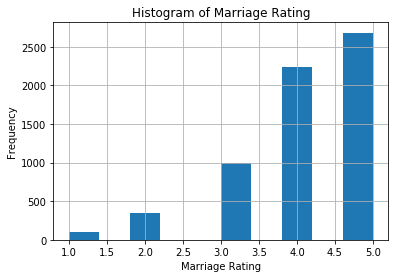

In [28]:
# histogram of marriage rating
df["rate_marriage"].hist()
plt.title("Histogram of Marriage Rating")
plt.xlabel("Marriage Rating")
plt.ylabel("Frequency")

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

Text(0, 0.5, 'Frequency')

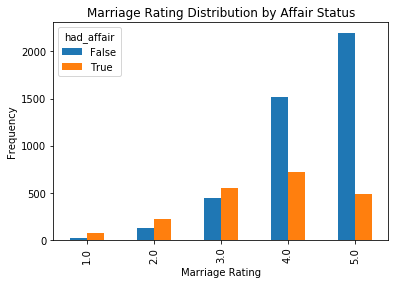

In [33]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(df["rate_marriage"], df["had_affair"].astype(bool)).plot(kind="bar")
plt.title("Marriage Rating Distribution by Affair Status")
plt.xlabel("Marriage Rating")
plt.ylabel("Frequency")

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0, 0.5, 'Percentage')

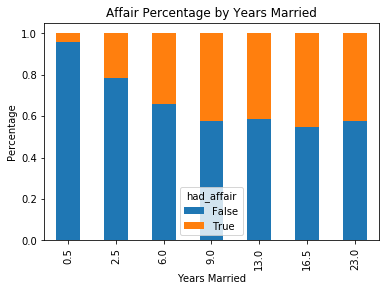

In [38]:
affair_yrs_married = pd.crosstab(df["yrs_married"], df["had_affair"].astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Affair Percentage by Years Married")
plt.xlabel("Years Married")
plt.ylabel("Percentage")

### Prepare Data for Logistic Regression

To prepare the data, I want to add an intercept column as well as dummy variables for occupation and occupation_husb, since I'm treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

In [72]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices("had_affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)",
                  df, return_type="dataframe")
X.columns

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

In [76]:
# The column names for the dummy variables are ugly, so let's rename those.
X = X.rename(columns = {"C(occupation)[T.2.0]":"occ_2",
                        "C(occupation)[T.3.0]":"occ_3",
                        "C(occupation)[T.4.0]":"occ_4",
                        "C(occupation)[T.5.0]":"occ_5",
                        "C(occupation)[T.6.0]":"occ_6",
                        "C(occupation_husb)[T.2.0]":"occ_husb_2",
                        "C(occupation_husb)[T.3.0]":"occ_husb_3",
                        "C(occupation_husb)[T.4.0]":"occ_husb_4",
                        "C(occupation_husb)[T.5.0]":"occ_husb_5",
                        "C(occupation_husb)[T.6.0]":"occ_husb_6"})

In [78]:
# We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)

### Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [80]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression(solver="lbfgs", max_iter = 1000)
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.726358781024191

73% accuracy seems good, but what's the null error rate?

In [82]:
# what percentage had affairs?
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

Let's examine the coefficients to see what we learn.

In [84]:
# examine the coefficients
X.columns, np.transpose(model.coef_)

(Index(['Intercept', 'occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2',
        'occ_husb_3', 'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage',
        'age', 'yrs_married', 'children', 'religious', 'educ'],
       dtype='object'), array([[-1.32119486e-02],
        [ 1.10614434e-01],
        [ 4.20422403e-01],
        [ 1.84974859e-01],
        [ 7.65912839e-01],
        [ 7.72824760e-01],
        [ 1.61378904e-01],
        [ 2.71887815e-01],
        [ 1.34470681e-01],
        [ 1.64516060e-01],
        [ 1.75876740e-01],
        [-7.08369099e-01],
        [-6.04982540e-02],
        [ 1.07436968e-01],
        [ 1.56154136e-02],
        [-3.73639772e-01],
        [-5.62959198e-04]]))

Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. For both the wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

### Model Evaluation Using a Validation Set

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [88]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression(solver="lbfgs", max_iter = 1000)
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [89]:
# predict class labels for the test set
predicted = model2.predict(X_test)
predicted

array([1., 0., 0., ..., 0., 0., 0.])

In [90]:
# generate class probabilities
probs = model2.predict_proba(X_test)
probs

array([[0.34768332, 0.65231668],
       [0.91191707, 0.08808293],
       [0.7271    , 0.2729    ],
       ...,
       [0.56238359, 0.43761641],
       [0.81070545, 0.18929455],
       [0.75015613, 0.24984387]])

As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.

Now let's generate some evaluation metrics.

In [91]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.7308900523560209
0.7463008315621914


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics.

In [94]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1168  135]
 [ 379  228]]
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      1303
         1.0       0.63      0.38      0.47       607

    accuracy                           0.73      1910
   macro avg       0.69      0.64      0.64      1910
weighted avg       0.71      0.73      0.71      1910



### Model Evaluation Using Cross-Validation

Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [97]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(solver="lbfgs", max_iter = 1000), X, y, scoring="accuracy", cv=10)
scores, scores.mean()

(array([0.72100313, 0.70219436, 0.73981191, 0.70597484, 0.70440252,
        0.73113208, 0.73427673, 0.70440252, 0.75471698, 0.74842767]),
 0.7246342737722048)

It's still performing at 73% accuracy.